<a href="https://colab.research.google.com/github/Diezelots/GDG/blob/main/%EA%B3%BC%EC%A0%9C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/서강대 화공/train.csv')

# 전처리
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]
df.dropna(inplace=True)  # 결측치 제거

# 범주형 → 숫자로 변환
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# 입력/출력 나누기
X = df.drop(columns=['Survived'])
y = df['Survived']

# 학습용/테스트용 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 스케일링 함수 정의 (수정하지 마세요)
def scale_age(X_train, X_test, scaler):
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled['Age'] = scaler.fit_transform(X_train[['Age']])
    X_test_scaled['Age'] = scaler.transform(X_test[['Age']])
    return X_train_scaled, X_test_scaled

# ✅ KNN 평가 함수 (수정하지 마세요)
def evaluate_knn(X_train, X_test, y_train, y_test, label):
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'{label:<20} Accuracy: {acc:.4f}')

# 1. 스케일링 없이 원본 데이터로 평가
evaluate_knn(X_train, X_test, y_train, y_test, "No Scaling")

# 2. StandardScaler 적용
X_train_std, X_test_std = scale_age(X_train, X_test, StandardScaler())
evaluate_knn(X_train_std, X_test_std, y_train, y_test, "StandardScaler")

# 3. MinMaxScaler 적용
X_train_minmax, X_test_minmax = scale_age(X_train, X_test, MinMaxScaler())
evaluate_knn(X_train_minmax, X_test_minmax, y_train, y_test, "MinMaxScaler")

# 4. RobustScaler 적용
X_train_robust, X_test_robust = scale_age(X_train, X_test, RobustScaler())
evaluate_knn(X_train_robust, X_test_robust, y_train, y_test, "RobustScaler")

No Scaling           Accuracy: 0.6643
StandardScaler       Accuracy: 0.7413
MinMaxScaler         Accuracy: 0.7413
RobustScaler         Accuracy: 0.7483


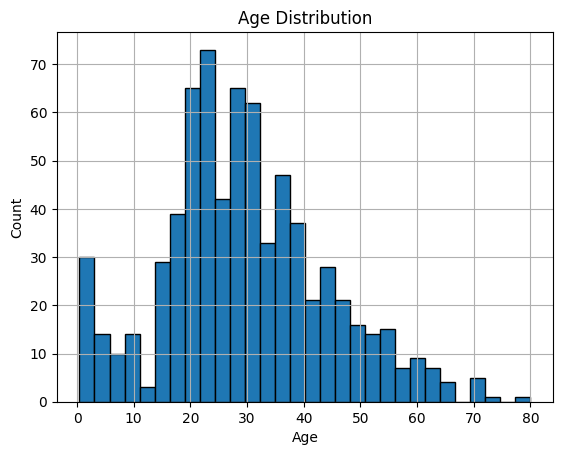

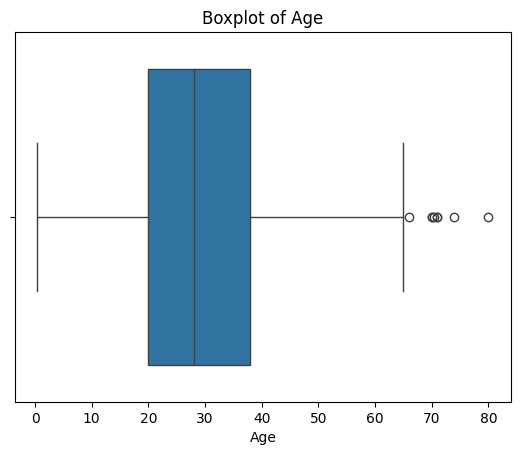

In [9]:
#나이 분포 표
plt.hist(df['Age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

#이상치 시각화
import seaborn as sns

sns.boxplot(x=df['Age'])
plt.title("Boxplot of Age")
plt.show()

결측치 처리:
1. Cabin은 열 자체를 삭제. Cabin의 정보를 활용하기에 다소 무리가 있으며, 결측치 또한 많아 열 전체를 삭제한다.
2. Embark에 NaN 값인 행은 삭제. Embark 결측치는 단 두개이므로 결측이 발생한 두 행을 삭제하는 것이 결과에 큰 영향을 미치지 않을 것으로 예상되기 때문.
3. Age 또한 NaN 값인 행 삭제. Age의 경우 결측치가 많지만 이를 평균값이나 최대, 최소값으로 임의로 넣을 경우 지나치게 작위적일 것으로 판단. 이는 Age가 생존율에 큰 영향을 미치기 때문이다.

스케일링:
1. 이상치 시각화(두번째 그림)를 통해 이상치가 다수 발생한다는 점을 발견. 따라서 이상치에 민감한 스케일링 방법 보단, 이상치에 강한 RobustScaler를 사용하는 것이 이상적이다.
---> 밑에 이상치를 제거한 이후에는 결과가 어떤지 살펴보자.

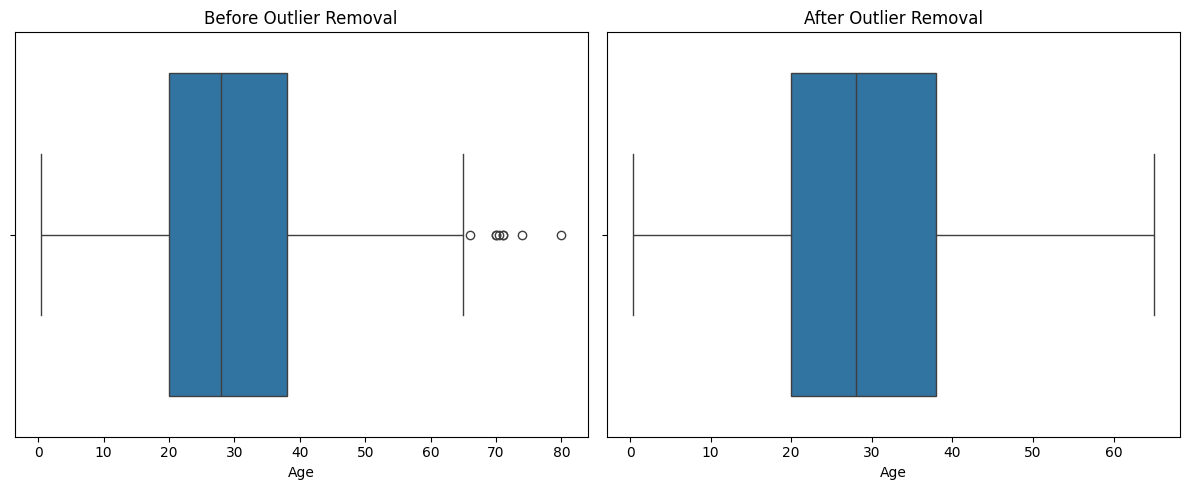

No Scaling           Accuracy: 0.6738
StandardScaler       Accuracy: 0.7234
MinMaxScaler         Accuracy: 0.7518
RobustScaler         Accuracy: 0.7305


In [13]:
# IQR 계산
Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 범위 기준 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
df_no_outliers = df[(df['Age'] >= lower_bound) & (df['Age'] <= upper_bound)]


plt.figure(figsize=(12, 5))

# 이상치 제거 전 시각화
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Age'])
plt.title("Before Outlier Removal")

# 이상치 제거 후 시각화
plt.subplot(1, 2, 2)
sns.boxplot(x=df_no_outliers['Age'])
plt.title("After Outlier Removal")
plt.tight_layout()
plt.show()

# 이상치 제거 후 스케일링
X = df_no_outliers.drop(columns=['Survived'])
y = df_no_outliers['Survived']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

def scale_age(X_train, X_test, scaler):
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled['Age'] = scaler.fit_transform(X_train[['Age']])
    X_test_scaled['Age'] = scaler.transform(X_test[['Age']])
    return X_train_scaled, X_test_scaled

# ✅ KNN 평가 함수 (수정하지 마세요)
def evaluate_knn(X_train, X_test, y_train, y_test, label):
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'{label:<20} Accuracy: {acc:.4f}')

# 1. 스케일링 없이 원본 데이터로 평가
evaluate_knn(X_train, X_test, y_train, y_test, "No Scaling")

# 2. StandardScaler 적용
X_train_std, X_test_std = scale_age(X_train, X_test, StandardScaler())
evaluate_knn(X_train_std, X_test_std, y_train, y_test, "StandardScaler")

# 3. MinMaxScaler 적용
X_train_minmax, X_test_minmax = scale_age(X_train, X_test, MinMaxScaler())
evaluate_knn(X_train_minmax, X_test_minmax, y_train, y_test, "MinMaxScaler")

# 4. RobustScaler 적용
X_train_robust, X_test_robust = scale_age(X_train, X_test, RobustScaler())
evaluate_knn(X_train_robust, X_test_robust, y_train, y_test, "RobustScaler")

스케일링:
1. 그러나 이상치를 제거하고 난 이후에는 결과가 달라진다. 이상치에 민감한 MinMaxScaler의 패널티가 사라지면서 가장 높은 정확도를 나타낸다.

In [3]:
df_raw = pd.read_csv('/content/drive/MyDrive/서강대 화공/train.csv')

# 전처리 전 정보 출력
print("전처리 전")
print(df_raw.info())
print("\n결측치 개수:\n", df_raw.isnull().sum())
print("\n샘플 데이터:\n", df_raw.head(3))

# 전처리 단계
df = df_raw[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']].copy()
df.dropna(inplace=True)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# 전처리 후 정보 출력
print("\n전처리 후")
print(df.info())
print("\n결측치 개수:\n", df.isnull().sum())
print("\n샘플 데이터:\n", df.head(3))

전처리 전
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

결측치 개수:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked      

결측치 삭제로 인해 기존 데이터 819개 -> 712개로 줄어든 것을 볼 수 있다. 또한 다루지 않기로 결정한 Cabin, Name 등의 열도 삭제된 모습이다. 마지막으로 Embarked, Sex와 같이 string 자료는 처리하기 쉽도록 숫자로 바뀐 모습.